# Predicting sex of household head in NFHS-3

This notebook works with `household_truncated.csv` (just as is on `data.world`) and tries to build a predictive algorithm for `HV219`: sex of household head.  The code could probably be reviewed and improved.  

Explanation for NFHS-3 and the project is on the [team GitHub project page](https://github.com/Data4Democracy/india-nfhs).

Codebook for variables is available in this folder at `IAHR52FL.txt`.

Written by Luke Wolcott.

## Table of contents

1. Import data, remove NAs

2. No Information model

3. Overly simple decision tree model, with five predictors

4. Decision tree with all 'interesting' variables

# 1. Import data, remove NAs

In [1]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import seaborn as sb 

%matplotlib inline
import matplotlib.pyplot as plt

# use low_memory = False so that it reads the dtypes correctly
df = pd.read_csv('household_truncated.csv', na_values='NaN', low_memory=False)

In [2]:
import warnings
warnings.filterwarnings('ignore') #Supress unnecessary warnings for readability

In [3]:
interesting = ['HV009','HV025', 'HV026', 'HV201', 'HV202', 'HV205', 'HV206', 'HV208', 'HV212', 'HV213',
              'HV214', 'HV215', 'HV216', 'HV217', 'HV219', 'HV220', 'HV221', 'HV226', 'HV227',
              'HV243A', 'HV244', 'HV246', 'HV247', 'HV270', 'SH44', 'SH46', 'SH47N', 'SH58', 
              'SH62A', 'SH62F', 'SHSLI', 'SHSTRUC']

In [4]:
# subset for 'interesting' variables
df2 = df[interesting]

In [5]:
# dict to easily keep track of which survey questions these variables correspond to
q_dict = {'HV009':'Number of listed household members' ,
          'HV025': 'Type of place of residence', 'HV026' : 'Place of residence',
          'HV201' : 'Source of drinking water', 'HV202':'Source of non-drinking water', 
          'HV205':'Type of toilet facility', 'HV206':'Has electricity', 
          'HV208':'Has television', 'HV212':'Has car', 'HV213':'Main floor material',
          'HV214':'Main wall [exterior] material', 'HV215':'Main roof material',
          'HV216':'Rooms used for sleeping', 'HV217':'Relationship structure',
          'HV219': 'Sex of head of household', 'HV220':'Age of head of household',
          'HV221':'Has telephone (non-mobile)', 
          'HV226':'Type of cooking fuel', 'HV227':'Have bednet for sleeping',
          'HV243A': 'Has mobile telephone',
          'HV244':'Owns land usable for agriculture', 'HV246':'Livestock, herds or farm animals',
          'HV247':'Owns a bank account or post office account', 'HV270':'Wealth Index',
          'SH44':'Household head\'s religion', 'SH46':'Type of caste or tribe of the HH head',
          'SH47N':'Has computer', 'SH58':'Owns this or any other house',
          'SH62A':'Has cows/bulls/buffalo', 'SH62F':'Has chickens',
          'SHSLI':'Standard of Living Index', 'SHSTRUC':'Household structure'}

In [6]:
var = 'HV025'
print(var + ': ' + q_dict[var])

HV025: Type of place of residence


In [7]:
stats = {'NAs': df2.isnull().sum(),
        'NAs_percent' : (df2.isnull().sum()/len(df2)*100).round(2),
        'DataType' : df2.dtypes}

stats = DataFrame(stats)
stats.index.name = 'Variables'
stats.columns.name = 'Stats'

In [26]:
stats[stats.NAs_percent > 0]

Stats,DataType,NAs,NAs_percent
Variables,,,
HV201,object,9,0.01
HV202,object,14,0.01
HV205,object,102,0.09
HV206,object,22,0.02
HV212,object,50,0.05
HV213,object,23,0.02
HV214,object,29,0.03
HV215,object,49,0.04
HV216,float64,106,0.10


## Handling NAs

There are not that many NAs, and we have lots of rows, so the easiest thing to do (instead of impuning values) is to simply remove rows with NAs.

In [8]:
df2.shape

(109041, 32)

In [9]:
df2 = df2.dropna(axis=0, how='any')

In [10]:
df2.shape

(101728, 32)

## Quickly check distribution of numerical variables

These are `HV216` (# of sleeping rooms), `HV220` (age of HH head), `HV009` (# of HH members).

0.00     3.0
0.25    35.0
0.50    45.0
0.75    57.0
1.00    98.0
Name: HV220, dtype: float64

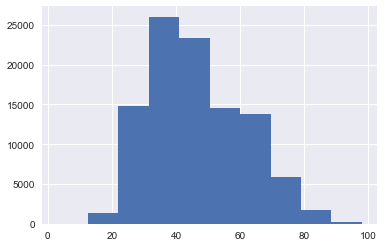

In [11]:
key = 'HV220'
x = df2[key]
x.hist()
x.quantile([0, .25, .5, .75, 1])


# 2. No Information Model

If we want to predict the sex of the head of the household, easiest thing is to just predict 'Male'.  This will be correct `85.6`% of the time.

In [12]:
# value counts for HV219
df2['HV219'].value_counts()

Male      87107
Female    14621
Name: HV219, dtype: int64

In [13]:
len(df2[df2['HV219'] == 'Male'])/len(df2)*100

85.62735923246304

# 3. Overly simple decision tree model, with few predictors

From my earlier EDA, I know that the main variables that relate to HV219 in an interesting way are:

- HV009: number of listed HH members (numerical)

- HV025: rural/urban (categorical)

- HV217: household structure (categorical)

- HV220: age of HH head (numerical)

- HV270: Wealth Index (categorical)

In [14]:
# for simplicity, restrict to these few columns
cols = ['HV009', 'HV025', 'HV217', 'HV220', 'HV270', 'HV219']
df = df2[cols]

In [15]:
# separate features and labels
df_all_features = df.drop(['HV219'], axis=1)
df_all_labels = df['HV219']

In [16]:
df_all_features.head()

Variables,HV009,HV025,HV217,HV220,HV270
0,6,Rural,Three+ related adults,60.0,Poorer
1,5,Rural,Three+ related adults,32.0,Poorer
2,1,Rural,One adult,60.0,Poorer
3,5,Rural,Three+ related adults,69.0,Middle
4,7,Rural,Three+ related adults,65.0,Middle


In [17]:
# get dummy categorical features
df_all_features = pd.get_dummies(df_all_features)
df_all_features.shape

(101728, 15)

In [18]:
df_all_features.columns

Index(['HV009', 'HV220', 'HV025_Rural', 'HV025_Urban', 'HV217_No adults',
       'HV217_One adult', 'HV217_Three+ related adults',
       'HV217_Two adults, opposite sex', 'HV217_Two adults, same sex',
       'HV217_Unrelated adults', 'HV270_Middle', 'HV270_Poorer',
       'HV270_Poorest', 'HV270_Richer', 'HV270_Richest'],
      dtype='object')

In [19]:
from sklearn.model_selection import train_test_split

# split manually into training/testing sets
(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(df_all_features, df_all_labels, train_size=0.75, random_state=1)

## Decision tree

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# create the classifier
dtc = DecisionTreeClassifier()

# train the classifier on the training set
%time dtc.fit(training_inputs, training_classes)

# validate the classifier on the testing set using classification accuracy
dtc.score(testing_inputs, testing_classes)

CPU times: user 296 ms, sys: 13.4 ms, total: 310 ms
Wall time: 348 ms


0.87995438817238125

We can repeat the fit many times and plot the model accuracies.

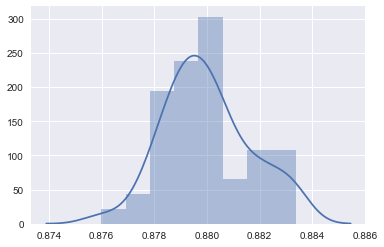

In [22]:
# do it many times and keep track of the model accuracies, then plot them
model_accuracies = []

for repetition in range(50):
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(df_all_features, df_all_labels, train_size=0.75)
    
    dtc = DecisionTreeClassifier()
    dtc.fit(training_inputs, training_classes)
    classifier_accuracy = dtc.score(testing_inputs, testing_classes)
    model_accuracies.append(classifier_accuracy)
    
sb.distplot(model_accuracies)

# 4. Decision tree with all 'interesting' variables

In [23]:
df2.shape

(101728, 32)

In [24]:
# separate features and labels
df2_all_features = df2.drop(['HV219'], axis=1)
df2_all_labels = df2['HV219']

In [25]:
# get dummy categorical features
df2_all_features = pd.get_dummies(df2_all_features)
df2_all_features.shape

(101728, 163)

In [26]:
from sklearn.model_selection import train_test_split

# split manually into training/testing sets
(training_inputs,
 testing_inputs,
 training_classes,
 testing_classes) = train_test_split(df2_all_features, df2_all_labels, train_size=0.75, random_state=1)

Now we're ready to build the model.

In [27]:
# create the classifier
dtc = DecisionTreeClassifier()

# train the classifier on the training set
%time dtc.fit(training_inputs, training_classes)

# validate the classifier on the testing set using classification accuracy
dtc.score(testing_inputs, testing_classes)

CPU times: user 2.97 s, sys: 108 ms, total: 3.08 s
Wall time: 3.37 s


0.83182604592639198

Worse than the No Information model.  Overwhelmed by all the dummy versions of categorical variables?

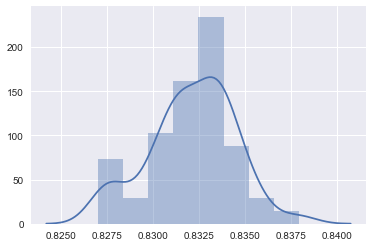

In [29]:
# do it many times and keep track of the model accuracies, then plot them
model_accuracies = []

for repetition in range(50):
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(df2_all_features, df2_all_labels, train_size=0.75)
    
    dtc = DecisionTreeClassifier()
    dtc.fit(training_inputs, training_classes)
    classifier_accuracy = dtc.score(testing_inputs, testing_classes)
    model_accuracies.append(classifier_accuracy)
    
sb.distplot(model_accuracies)